# 4. Community EDA

In [1]:
import pandas as pd
import numpy as np
import dgl
import torch as th
from sklearn.preprocessing import StandardScaler
from more_itertools import flatten

import seaborn as sns
import matplotlib.pyplot as plt

# Import Data

In [2]:
# import new data after feature engineering
wires = pd.read_csv('wires.csv').iloc[:, 1:]
emts = pd.read_csv('emts.csv').iloc[:, 1:]
cash = pd.read_csv('cash.csv').iloc[:, 1:]
cust_info = pd.read_csv('cust_info.csv').iloc[:, 1:]
detail_cust = pd.read_csv('detailed_cust_info.csv').iloc[:, 1:]
ext_info = pd.read_csv('external_info.csv').iloc[:, 1:]

In [3]:
# convert the amount in cash df to type float
cash['amount'] = cash['amount'].astype(float)

In [4]:
# Import community Labels
coms_df = pd.read_csv('Community_labels.csv').iloc[:, 1:]

# Get Customer Data

In [5]:
# Import detailed data with occupations
dci = pd.read_csv('dci.csv').iloc[:, 1:]
dci

,Global_id,Occupation,Age,Tenure,label,Gender_female,Gender_male,Occupation_num,Num_wires_sent,Avg_wire_amt_sent,...,Num_wire_sent_dom,Avg_wire_sent_dom,Num_emt_rec_ext,Avg_emt_rec_ext,Num_emt_sent_ext,Avg_emt_sent_ext,Num_emt_rec_int,Avg_emt_rec_int,Num_emt_sent_int,Avg_emt_sent_int
0,102123,Architect,45.0,13.0,0,1,0,8,2,1985.75,...,2,1985.75,2,448.000000,3,2023.666667,6,1764.750000,4,2085.250
1,83128,Musician,52.0,8.0,0,0,1,146,0,0.00,...,0,0.00,1,84.000000,0,0.000000,0,0.000000,0,0.000
2,80244,Jewelry Dealer,43.0,11.0,0,1,0,115,2,14131.50,...,1,1305.00,6,279.666667,1,168.000000,7,694.357143,4,1081.500
3,93124,Real Estate Broker,39.0,21.0,1,0,1,195,2,5214.50,...,2,5214.50,7,2195.285714,1,55.000000,1,2922.000000,4,273.125
4,44548,Sommelier,26.0,8.0,0,1,0,212,0,0.00,...,0,0.00,1,10.000000,0,0.000000,0,0.000000,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126178,80822,Private Equity Fund Manager,37.0,12.0,1,1,0,186,0,0.00,...,0,0.00,2,31.000000,0,0.000000,1,32.000000,4,31.250
126179,18375,Software Developer,46.0,3.0,0,0,1,211,0,0.00,...,0,0.00,6,308.250000,1,220.000000,7,204.428571,2,284.750
126180,10812,Miner,31.0,10.0,0,0,1,143,0,0.00,...,0,0.00,1,634.000000,0,0.000000,0,0.000000,0,0.000
126181,23226,Unknown,21.0,3.0,0,1,0,235,0,0.00,...,0,0.00,3,407.000000,0,0.000000,4,531.625000,8,590.000


# Get the broad occupation categories

In [6]:
# Create broader categories for Occupation
sports = ['Sports Agent']

gamble = ['Online Gambling Site Operator', 'Casino Operator']

sales = ['Retail Salesperson', 'International Salesperson', 
         'Telemarketer']

valuables = ['Antiques Dealer', 'Gemologist', 
             'Pawn Shop Owner', 'Auctioneer', 'Antique Dealer', 
             'Precious Metals Dealer', 'Luxury Goods Dealer (e.g., Art, Jewelry)', 
             'Jewelry Dealer', 'Local Fair Operator']

estate = ['Real Estate Broker', 'High-End Real Estate Developer', 'Property Manager', 
          'Real Estate Agent', 'Landlord']

owners = ['Nightclub or Bar Owner', 'Business Owner', 'Currency Exchange Owner', 
          'Private Security Company Owner', 'Cash-intensive Business Owner (e.g., Laundromat)', 
          'Loan or Finance Company Owner', 'Payment Processors Owner', 'Money Service Business Owner', 
          'Hotelier']

brokers = ['Luxury Yacht Broker', 'Commodity Broker', 
           'Private Jet Broker', 'Stock Broker']

finance = ['Offshore Trustee', 'Private Banker', 
            'Venture Capitalist', 'Private Equity Fund Manager', 
           'Hedge Fund Manager', 'Non-profit Organization Director', 
            'Virtual Asset Service Providers', 'Offshore Investment Advisor', 
            'Corporate Executive', 'Free Trade Zone Operator',
            'Cryptocurrency Trader', 'Shell Company Operator', 'Actuary', 
            'Banker', 'Economist', 'Financial Advisor', 'Tax Advisor', 
            'Trust and Company Service Provider']

animal = ['Pet Groomer', 'Biologist', 'Ichthyologist', 
          'Veterinarian', 'Malacologist', 
          'Veterinarian Assistant', 'Farmer',  
          'Animal Trainer', 'Zookeeper', 
          'Paleontologist', 'Beekeeper', 
          'Herpetologist', 'Farm Laborer', 'Oceanographer', 
          'Fisherman', 'Marine Biologist', 
          'Ornithologist',  'Nematologist', 'Entomologist', 
          'Lepidopterist']

food = ['Butcher', 'Chef', 'Food Scientist', 'Baker', 'Barista', 
        'Barista', 'Bartender', 'Brewer', 'Coffee Roaster', 
        'Dietician', 'Distiller', 'Enologist', 'Food Critic', 
        'Pastry Chef', 'Sommelier']

enviro = ['Hydrologist', 'Environmental Scientist', 'Bioengineer', 
          'Limnologist','Forester', 'Marine Engineer', 'Dendrochronologist',
          'Glaciologist', 'Volcanologist', 'Miner', 'Arborist', 
          'Seismologist', 'Mycologist', 'Cryoseismologist', 'Arborist', 
          'Archaeologist', 'Astronomer', 'Florist', 'Gardener', 'Geologist', 
          'Meteorologist', 'Urban Planner', 'Landscaper']

transport = ['Import/Export Dealer', 'Bus Driver', 'Postal Worker', 'Warehouse Worker', 
             'Auto Dealer', 'Taxi Driver', 'School Bus Driver', 
             'Mechanic', 'Flight Attendant', 'Travel Agent', 
             'Maritime or Shipping Agent', 'Pilot', 'Travel Agency Owner', 
             'Import/Export Business Owner', 'Car Dealership Owner']

health = ['Psychologist', 'Research Scientist', 'Doctor', 
          'Research Scientist', 'Astrophysicist', 'Political Scientist', 
          'Chiropractor', 'Chemist', 'Pedologist', 'Dentist', 
          'Home Health Aide', 'Pediatrician', 'Nurse', 'Pharmacist', 
          'Therapist', 'Massage Therapist', 'Physical Therapist', 
          'Radiologist', 'Ethnobotanist', 'Physicist', 
          'Kinesiologist', 'Paramedic', 'Surgeon', 'Anesthesiologist', 
          'Osteologist', 'Nutritionist', 'Fitness Trainer', 'Optometrist']

niche = ['Cartographer', 'Ceramicist',  'Ethnomusicologist', 
         'Graphologist', 'Numismatist', 'Philatelist', 
         'Semiotician', 'Vexillologist']

study = ['Egyptologist', 'Sinologist', 'Linguist', 
         'Historian', 'Sociologist']

film = ['Actor', 'Film Editor', 'Filmmaker', 'Set Designer', 
        'TV Producer', 'Theater Director', 'Videographer', 
        'Voice Actor']

music = ['DJ', 'Local Radio Operator', 'Luthier', 
         'Music Producer', 'Musician', 'Radio Host', 
         'Sound Engineer', 'Choreographer']

art = ['Artist', 'Art Gallery Owner', 'Art Dealer', 
       'Cicerone', 'Curator', 'Art Critic', 
       'Art Historian', 'Graphic Artist', 'Printmaker', 
       'Tattoo Artist', 'Fashion Designer', 'Sculptor']

books = ['Author', 'Cartoonist', 'Comic Book Artist', 
         'Freelancer (e.g., Graphic Designer, Writer)', 
         'Illustrator', 'Librarian', 'Librarian Assistant', 
         'Librettist', 'Literary Critic', 'Book Editor']

building = ['Architect', 'Carpenter', 'Construction Contractor', 
            'Construction Worker', 'Electrician', 
            'Interior Designer']

services = ['Makeup Artist', 'Event Planner', 'Cleaner', 
            'Plumber', 'Window Cleaner', 'Cashier', 'Civil Servant',
           'Fast Food Worker', 'Grocery Store Clerk', 
            'Hairstylist', 'Photographer', 'Social Worker', 
            'Waiter/Waitress', 'Wedding Planner', 'Tailor', 
            'Lifeguard', 'Firefighter', 'Police Officer', 
            'Security Guard', 'Translator','Tour Guide', 
            'Call Center Representative', 'Receptionist', 
            'Factory Worker', 'International Consultant']

student = ['Childcare Worker', 'Private Tutor', 'Nanny', 'School Teacher', 
           'Student', 'University Professor']

code = ['Engineer', 'Game Developer', 'Software Developer']

news = ['Journalist', 'Lawyer', 'News Anchor', 
        'Notary Public']

stats = ['Statistician', 'Surveyor']

vague = ['Other', 'Unknown', 'Retired', 'Unemployed']

In [7]:
# Create a list storing the different categories
cates = [sports, gamble, sales, valuables, estate, owners, brokers, finance, animal, food, enviro, transport, health, niche, study, film, music, art, books, building, services, student, code, news, stats, vague]

In [8]:
# create a list to store the names of the variables
names = ['sports', 'gamble', 'sales', 'valuables', 'estate', 'owners', 'brokers', 'finance', 'animal', 'food', 'enviro', 'transport', 'health', 'niche', 'study', 'film', 'music', 'art', 'books', 'building', 'services', 'student', 'code', 'news', 'stats', 'vague']

In [9]:
# create a copy of the kyc data and add new variables based on occupation categories
ind_info = dci.copy()

In [10]:
# loop through the categories and add booleans for whether individual's occupation is in that category
for i in range(len(cates)):
    
    # Get boolean for whether individual falls in the occupation category
    b = dci['Occupation'].isin(cates[i])
    
    # get variable name
    var_name = names[i]
    
    # set record to 1 for var if individual is in occupation category
    ind_info.loc[b, var_name] = 1
    
# fill null values (those not equal to 1) to 0
ind_info = ind_info.fillna(0)

# convert to int
for name in names:
    ind_info[name] = ind_info[name].astype(int)

In [11]:
# Get only occupation related variables
occ_cols = ['Global_id'] + list(ind_info.iloc[:, 44:].columns)
occ_info = ind_info[occ_cols]
occ_info

,Global_id,sports,gamble,sales,valuables,estate,owners,brokers,finance,animal,...,music,art,books,building,services,student,code,news,stats,vague
0,102123,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,83128,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,80244,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,93124,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,44548,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126178,80822,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
126179,18375,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
126180,10812,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
126181,23226,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [12]:
ind_info

,Global_id,Occupation,Age,Tenure,label,Gender_female,Gender_male,Occupation_num,Num_wires_sent,Avg_wire_amt_sent,...,music,art,books,building,services,student,code,news,stats,vague
0,102123,Architect,45.0,13.0,0,1,0,8,2,1985.75,...,0,0,0,1,0,0,0,0,0,0
1,83128,Musician,52.0,8.0,0,0,1,146,0,0.00,...,1,0,0,0,0,0,0,0,0,0
2,80244,Jewelry Dealer,43.0,11.0,0,1,0,115,2,14131.50,...,0,0,0,0,0,0,0,0,0,0
3,93124,Real Estate Broker,39.0,21.0,1,0,1,195,2,5214.50,...,0,0,0,0,0,0,0,0,0,0
4,44548,Sommelier,26.0,8.0,0,1,0,212,0,0.00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126178,80822,Private Equity Fund Manager,37.0,12.0,1,1,0,186,0,0.00,...,0,0,0,0,0,0,0,0,0,0
126179,18375,Software Developer,46.0,3.0,0,0,1,211,0,0.00,...,0,0,0,0,0,0,1,0,0,0
126180,10812,Miner,31.0,10.0,0,0,1,143,0,0.00,...,0,0,0,0,0,0,0,0,0,0
126181,23226,Unknown,21.0,3.0,0,1,0,235,0,0.00,...,0,0,0,0,0,0,0,0,0,1


In [13]:
# export ind info
ind_info.to_csv('ind_info.csv')

# Create Master Transactions dataframe

Create a dataframe to store the transaction id and the people involved in the transaction.

In [14]:
# create a function to get the trxn ids and people involved
def get_people(df, cash):
    """
    """
    if cash:
        p1 = df[['trxn_id', 'Global_id']].rename(columns={'Global_id': 'Global_ids'})
    else:
        p = df[['trxn_id', 'sender_global_id', 'rec_global_id']]
        p['Global_ids'] = p.apply(lambda x: [x['sender_global_id'], x['rec_global_id']], axis=1)
        p1 = p[['trxn_id', 'Global_ids']]
    
    return p1

In [15]:
# get the people for wire transactions
w = get_people(wires, False)
e = get_people(emts, False)
c = get_people(cash, True)

C:\Users\syou1\AppData\Local\Temp\ipykernel_25176\4115735627.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p['Global_ids'] = p.apply(lambda x: [x['sender_global_id'], x['rec_global_id']], axis=1)
C:\Users\syou1\AppData\Local\Temp\ipykernel_25176\4115735627.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p['Global_ids'] = p.apply(lambda x: [x['sender_global_id'], x['rec_global_id']], axis=1)


In [16]:
# Export the individual frames
e.to_csv('e.csv')
w.to_csv('w.csv')
c.to_csv('c.csv')

### Concat into one dataframe

In [17]:
master = pd.concat([w, e, c])
master

,trxn_id,Global_ids
0,LWCS42954834,"[46393, 118403]"
1,NTTG55749308,"[101584, 183844]"
2,IXVD84599097,"[184551, 104548]"
3,SLBV29462341,"[71803, 162608]"
4,ERLU26785367,"[117672, 9197]"
...,...,...
90224,JOQU43611104,85640
90225,LTBH81014009,105558
90226,GGHM25093698,42954
90227,CNXP31340871,23527


In [18]:
# export the master transaction dataframe
master.to_csv('master.csv')

# Extract Community Subgraphs

In [19]:
# Show the community dataframe
coms_df

,trxn_id,Community Label
0,LWCS42954834,132
1,NTTG55749308,7252
2,IXVD84599097,228
3,SLBV29462341,82
4,ERLU26785367,9
...,...,...
457416,JOQU43611104,866
457417,LTBH81014009,231
457418,GGHM25093698,213113
457419,CNXP31340871,213114


In [20]:
# Group by community to find the transactions id for each community
gpby_comm = pd.DataFrame(coms_df.groupby(['Community Label'])['trxn_id'].unique()).reset_index()
gpby_comm

,Community Label,trxn_id
0,0,"[NHIA18852481, VKQD46541387, ADIC38899959, SIF..."
1,1,"[JGOZ57737480, GXAD59299067, WSXM18690984, BEM..."
2,2,"[ROCE99353654, TRRC12340118, WTFQ82471832, NEV..."
3,3,"[RCGE32796965, RRPD10035387, WPSD16471846, IDG..."
4,4,"[BLWI99232365, OTUT66829537, XEUP24479648, MEE..."
...,...,...
213138,213138,[CNKN92932390]
213139,213139,[UIBP27938836]
213140,213140,[VTEM86192546]
213141,213141,[ZXIA93015631]


In [21]:
# Show the number of transactions for each community
gpby_comm['Num_trxns'] = gpby_comm['trxn_id'].apply(lambda x: len(x))
gpby_comm

,Community Label,trxn_id,Num_trxns
0,0,"[NHIA18852481, VKQD46541387, ADIC38899959, SIF...",1871
1,1,"[JGOZ57737480, GXAD59299067, WSXM18690984, BEM...",1603
2,2,"[ROCE99353654, TRRC12340118, WTFQ82471832, NEV...",1449
3,3,"[RCGE32796965, RRPD10035387, WPSD16471846, IDG...",1446
4,4,"[BLWI99232365, OTUT66829537, XEUP24479648, MEE...",1412
...,...,...,...
213138,213138,[CNKN92932390],1
213139,213139,[UIBP27938836],1
213140,213140,[VTEM86192546],1
213141,213141,[ZXIA93015631],1


### Extract community members

In [22]:
# Initialize an empty dictionary
comms = {}

# Iterate through each row in the DataFrame
for index, row in gpby_comm.iterrows():
    # Use Column1 values as keys and Column2 values as values
    comms[row['Community Label']] = list(row['trxn_id'])

In [23]:
# Create a dictionary to store the individuals involved for each community
subgraphs = {}

In [24]:
labels = list(gpby_comm['Community Label'].values)

In [25]:
for label in labels:
    # Get list of trxns for the community
    trxn_list = comms[label]
    
    # Find the transactions in the master transactions
    trxn_df = master[master['trxn_id'].isin(trxn_list)]
    
    # Get the list of people from the dataframe
    people = list(trxn_df['Global_ids'].values)
    
    # store the people list as the values in the dictionary
    subgraphs[label] = people

In [26]:
len(subgraphs)

213143

In [27]:
# show subgraph example
subgraphs[0][:5]

[[125060, 137210],
 [33412, 114327],
 [75006, 136059],
 [70210, 143978],
 [34463, 133479]]

## Get customer/external data for corresponding community members

In [29]:
def flatten(lst):
    for item in lst:
        # Check if the item is a list
        if isinstance(item, list):
            # Recursively flatten the list
            yield from flatten(item)
        else:
            yield item  # Yield non-list items directly

In [30]:
# Get the people for each community and store the corresponding customer/external dataframes for them
com_data = {}

In [31]:
for i in range(len(subgraphs)):
    
    # Get the list of people in the community
    com_people = subgraphs[i]
    
    # flatten the list of people
    com_p = flatten(com_people)
    
    # Get the customers data
    cust_data = ind_info[ind_info['Global_id'].isin(com_p)]
    
    # Get the externals data
    com_ext = ext_info[ext_info['Global_id'].isin(com_p)]
    
    # Create a dictionary to store the data 
    data = {'customers': cust_data, 'externals': com_ext}
    
    # Add the data to the communities data dict
    com_data[i] = data

In [32]:
# Show com_data example
com_data[0]['customers']

,Global_id,Occupation,Age,Tenure,label,Gender_female,Gender_male,Occupation_num,Num_wires_sent,Avg_wire_amt_sent,...,music,art,books,building,services,student,code,news,stats,vague
212,122846,Student,29.0,3.0,0,1,0,217,0,0.0,...,0,0,0,0,0,1,0,0,0,0
294,42777,Cartographer,32.0,13.0,0,0,1,34,0,0.0,...,0,0,0,0,0,0,0,0,0,0
636,53213,Astronomer,29.0,3.0,0,1,0,14,0,0.0,...,0,0,0,0,0,0,0,0,0,0
780,119911,Art Dealer,59.0,18.0,1,1,0,10,1,4107.0,...,0,1,0,0,0,0,0,0,0,0
907,17638,Hotelier,60.0,4.0,0,0,1,106,1,1954.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125015,41586,Unemployed,45.0,7.0,0,0,0,233,0,0.0,...,0,0,0,0,0,0,0,0,0,1
125061,71014,Electrician,32.0,14.0,0,1,0,66,0,0.0,...,0,0,0,1,0,0,0,0,0,0
125958,102238,Sports Agent,37.0,5.0,0,0,1,214,0,0.0,...,0,0,0,0,0,0,0,0,0,0
126021,95083,School Bus Driver,40.0,15.0,0,1,0,200,0,0.0,...,0,0,0,0,0,0,0,0,0,0


# Identify HRIs in each community

In [34]:
# create lists to store the counts and totals for each community
counts = []
totals = []
HRI_animal_bools = []
HRI_transport_bools = []

In [35]:
# Count the number of label 1 individuals for each community
# and create flag if there is a HRI with animal or transport 
for i in range(len(com_data)):
    count = 0
    bool_HRIa = 0
    bool_HRIt = 0
    
    # Get dataframe
    df = com_data[i]['customers']
    
    # check if customers/external dataframe is non-empty
    if len(df) > 0:
        count += df['label'].sum()
        
        # check fo HRI in animal occupation
        ani_df = df[(df['label'] == 1) & (df['animal'] == 1)]
        if len(ani_df) > 1:
            bool_HRIa = 1
        
        # check for HRI in transportation
        trans_df = df[(df['label'] == 1) & (df['transport'] == 1)]
        if len(trans_df) > 1:
            bool_HRIt = 1
    
    # No need to check for externals since they don't have label data 
    # Get the total amount of people in the community
    total = len(com_data[i]['customers']) + len(com_data[i]['externals'])
    
    # append info to lists
    counts.append(count)
    totals.append(total)
    HRI_animal_bools.append(bool_HRIa)
    HRI_transport_bools.append(bool_HRIt)

In [40]:
# Create a dataframe for the counts
HRI_data = {'Count HRIs': counts, 'Total Members': totals, 
            'HRI Animal-Related': HRI_animal_bools, 'HRI Transport-Related': HRI_transport_bools}
com_HRIs = pd.DataFrame(HRI_data).reset_index()
com_HRIs = com_HRIs.rename(columns={'index': 'Community Label'})
com_HRIs

,Community Label,Count HRIs,Total Members,HRI Animal-Related,HRI Transport-Related
0,0,63,734,0,1
1,1,57,645,0,1
2,2,56,603,0,1
3,3,50,594,0,1
4,4,45,493,1,1
...,...,...,...,...,...
213138,213138,1,1,0,0
213139,213139,1,1,0,0
213140,213140,0,1,0,0
213141,213141,0,2,0,0


In [222]:
com_HRIs.sort_values(by='Total Members', ascending=False)

,Community Label,Count HRIs,Total Members,HRI Animal-Related,HRI Transport-Related,Percent HRIs
0,0,63,734,0,1,0.085831
1,1,57,645,0,1,0.088372
2,2,56,603,0,1,0.092869
3,3,50,594,0,1,0.084175
6,6,47,567,0,1,0.082892
...,...,...,...,...,...,...
87332,87332,0,1,0,0,0.000000
87333,87333,0,1,0,0,0.000000
87334,87334,0,1,0,0,0.000000
87335,87335,0,1,0,0,0.000000


In [41]:
# Group by total members
gpby_total = pd.DataFrame(com_HRIs.groupby(['Total Members'])['Community Label'].count()).rename(columns={'Community Label': 'Number of Communities'})
gpby_total

,Number of Communities
Total Members,
1,149822
2,59102
3,1343
4,725
5,457
...,...
567,1
594,1
603,1


In [44]:
# Calculate the percentage of HRIs in each community
com_HRIs['Percent HRIs'] = com_HRIs['Count HRIs'] / com_HRIs['Total Members']
com_HRIs

,Community Label,Count HRIs,Total Members,HRI Animal-Related,HRI Transport-Related,Percent HRIs
0,0,63,734,0,1,0.085831
1,1,57,645,0,1,0.088372
2,2,56,603,0,1,0.092869
3,3,50,594,0,1,0.084175
4,4,45,493,1,1,0.091278
...,...,...,...,...,...,...
213138,213138,1,1,0,0,1.000000
213139,213139,1,1,0,0,1.000000
213140,213140,0,1,0,0,0.000000
213141,213141,0,2,0,0,0.000000


In [224]:
# Find the average total number of members for communities that are 100% HRI
com_HRIs[com_HRIs['Percent HRIs'] == 1]['Total Members'].mean()

1.0050995229478532

In [45]:
# Filter for communities that have an HRI with animal occupation
focus = com_HRIs[com_HRIs['HRI Animal-Related'] == 1]
focus

,Community Label,Count HRIs,Total Members,HRI Animal-Related,HRI Transport-Related,Percent HRIs
4,4,45,493,1,1,0.091278
13,13,57,520,1,1,0.109615
31,31,52,446,1,1,0.116592
32,32,37,411,1,1,0.090024
38,38,24,357,1,1,0.067227
138,138,24,223,1,1,0.107623
147,147,28,245,1,1,0.114286
148,148,28,251,1,1,0.111554
151,151,40,265,1,1,0.150943
227,227,20,192,1,1,0.104167


In [48]:
# Get averages
focus['Total Members'].mean()

321.09090909090907

In [49]:
focus['Count HRIs'].mean()

33.36363636363637

In [218]:
focus['Total Members'].mean()

321.09090909090907

In [51]:
focus['Percent HRIs'].mean()

0.10512114192986731

In [50]:
# Filter for communities that have an HRI with transportation occupation
focus2 = com_HRIs[com_HRIs['HRI Transport-Related'] == 1]
focus2

,Community Label,Count HRIs,Total Members,HRI Animal-Related,HRI Transport-Related,Percent HRIs
0,0,63,734,0,1,0.085831
1,1,57,645,0,1,0.088372
2,2,56,603,0,1,0.092869
3,3,50,594,0,1,0.084175
4,4,45,493,1,1,0.091278
...,...,...,...,...,...,...
590,590,5,19,0,1,0.263158
1129,1129,2,5,0,1,0.400000
1245,1245,2,3,0,1,0.666667
3492,3492,2,5,0,1,0.400000


In [53]:
# sort the values and plot the top 10 communities with the highest %HRI given Total Members > 1
focus_HRI = com_HRIs[(com_HRIs['Total Members'] > 1) & (com_HRIs['Percent HRIs'] > 0)]
focus_HRI = focus_HRI.sort_values(by=['Total Members', 'Percent HRIs'], ascending=False)
focus_HRI[:50]

,Community Label,Count HRIs,Total Members,HRI Animal-Related,HRI Transport-Related,Percent HRIs
0,0,63,734,0,1,0.085831
1,1,57,645,0,1,0.088372
2,2,56,603,0,1,0.092869
3,3,50,594,0,1,0.084175
6,6,47,567,0,1,0.082892
7,7,45,557,0,1,0.080790
14,14,45,539,0,1,0.083488
8,8,45,530,0,1,0.084906
13,13,57,520,1,1,0.109615
17,17,50,520,0,1,0.096154


In [57]:
# filter for Total Members > 10 and Percent HRIs > 10%
filtered = focus_HRI[(focus_HRI['Total Members'] > 10) & (focus_HRI['Percent HRIs'] > 0.10)]
filtered = filtered.sort_values(by=['Percent HRIs', 'Total Members'], ascending=False)
filtered

,Community Label,Count HRIs,Total Members,HRI Animal-Related,HRI Transport-Related,Percent HRIs
466,466,6,14,0,0,0.428571
467,467,5,13,0,0,0.384615
805,805,4,12,0,0,0.333333
609,609,4,13,0,0,0.307692
650,650,4,13,0,0,0.307692
...,...,...,...,...,...,...
79,79,31,307,0,1,0.100977
171,171,25,248,0,1,0.100806
62,62,34,338,0,1,0.100592
136,136,28,279,0,1,0.100358


# Investigations

### Create functions to investigate communities

In [58]:
# create a function to recode the Gender column
def recode_gender(cust_data):
    """
    """
    # Recode Gender column
    cust_data.loc[(cust_data['Gender_female'] == 1),'Gender'] = 'Female'
    cust_data.loc[(cust_data['Gender_male'] == 1),'Gender'] = 'Male'
    cust_data['Gender'] = cust_data['Gender'].fillna('Other')
    
    return cust_data

In [59]:
# Create function to find the number of members in the community in each occupation category 
def find_cat_counts(com_num):
    """
    """
    
    # Get the customer data for com_num
    cust_data = com_data[com_num]['customers']
    
    # Get occupation data and merge
    occ_data = occ_info[occ_info['Global_id'].isin(cust_data['Global_id'].values)]

    # Sum the values for each of the occupation columns to get the number of individuals in each occupation
    summary_occs = pd.DataFrame(occ_data.iloc[:, 1:].sum()).reset_index()
    summary_occs = summary_occs.rename(columns={0:'Num Members', 'index': 'Occupation Category'})
    summary_occs = summary_occs.sort_values(by=['Num Members'], ascending=False)

    # Drop the cateories that are = 0
    summary_occs = summary_occs[summary_occs['Num Members'] > 0]
    
    return summary_occs

# Investigate Benchmark (All customer stats)

In [217]:
bench = pd.DataFrame(dci.iloc[:, 8:].mean())
bench

,0
Num_wires_sent,0.217525
Avg_wire_amt_sent,749.991991
Num_wires_received,0.281433
Avg_wire_amt_received,939.829160
Num_emts_sent,1.550201
Avg_emt_amt_sent,305.672766
Num_emt_received,1.944438
Avg_emt_amt_received,344.495845
Num_deposit,0.437658
Num_withdrawal,0.277407


# Investigate Target Communities

### Get Transaction Detail Summary for the focus 11 communities

In [109]:
aid = list(focus['Community Label'].values)
aid

[4, 13, 31, 32, 38, 138, 147, 148, 151, 227, 379]

In [129]:
len(aid)

11

In [173]:
trxn_details = []

In [174]:
# loop through the animal-related HRI communities and append customer data to trxn_details
for i in range(len(aid)):
    cust_data = com_data[aid[i]]['customers']
    trxn_df = pd.DataFrame(cust_data.iloc[:, 8:44].mean()).reset_index()
    trxn_details.append(trxn_df)

In [175]:
len(trxn_details)

11

In [176]:
t = trxn_details[0]

In [177]:
trxn_details.pop(0)

,index,0
0,Num_wires_sent,0.513185
1,Avg_wire_amt_sent,1564.711697
2,Num_wires_received,0.626775
3,Avg_wire_amt_received,1616.935683
4,Num_emts_sent,2.444219
5,Avg_emt_amt_sent,446.025759
6,Num_emt_received,3.079108
7,Avg_emt_amt_received,508.563950
8,Num_deposit,1.018256
9,Num_withdrawal,0.584178


In [178]:
# Merge all of the customer dataframes in trxn_details to one dataframe
for i in range(len(trxn_details)):
    suffixes = (f'_x{i}', f'_y{i}')
    t = pd.merge(t, trxn_details[i], on='index', suffixes=suffixes)

In [180]:
t.columns = ['Metric'] + aid

In [181]:
t = t.set_index('Metric')

In [185]:
t = t.transpose()

In [186]:
# Show the average transaction details for each community. 
# The first column Metric should be renamed 'Community Label'
t

Metric,Num_wires_sent,Avg_wire_amt_sent,Num_wires_received,Avg_wire_amt_received,Num_emts_sent,Avg_emt_amt_sent,Num_emt_received,Avg_emt_amt_received,Num_deposit,Num_withdrawal,...,Num_wire_sent_dom,Avg_wire_sent_dom,Num_emt_rec_ext,Avg_emt_rec_ext,Num_emt_sent_ext,Avg_emt_sent_ext,Num_emt_rec_int,Avg_emt_rec_int,Num_emt_sent_int,Avg_emt_sent_int
4,0.513185,1564.711697,0.626775,1616.935683,2.444219,446.025759,3.079108,508.563950,1.018256,0.584178,...,0.454361,1239.157049,1.322515,395.987623,0.912779,286.569622,1.756592,393.097908,1.531440,393.827083
13,0.563462,1861.117083,0.676923,1542.789457,2.503846,542.405642,3.586538,586.600063,1.063462,0.684615,...,0.500000,1348.152420,1.700000,417.547678,0.871154,356.406122,1.886538,506.867661,1.632692,463.471622
31,0.558296,2093.943909,0.645740,1875.991488,2.845291,531.396248,4.080717,515.736118,0.849776,0.573991,...,0.497758,1502.128924,1.988789,401.030617,1.085202,398.995533,2.091928,422.515703,1.760090,426.714739
32,0.462287,1484.094404,0.562044,1984.954756,2.798054,474.478487,3.990268,512.674686,0.892944,0.527981,...,0.408759,1065.172689,1.883212,321.662375,1.046229,289.279130,2.107056,466.615723,1.751825,407.205293
38,0.459384,1930.259944,0.535014,1418.885761,2.551821,436.047371,3.319328,480.325603,0.719888,0.495798,...,0.417367,1384.421709,1.621849,353.052683,0.955182,290.799043,1.697479,407.989030,1.596639,380.776379
138,0.515695,1833.720217,0.825112,2082.605643,3.134529,475.049390,4.134529,590.938626,0.892377,0.605381,...,0.443946,1204.022608,1.919283,423.448785,1.242152,351.716117,2.215247,572.552941,1.892377,420.919545
147,0.608163,2423.766025,0.681633,2106.537483,2.979592,393.174777,4.253061,543.444063,1.191837,0.775510,...,0.489796,1366.694699,2.036735,431.508451,1.114286,282.260408,2.216327,430.081845,1.865306,360.523040
148,0.625498,2156.869323,0.745020,2126.579028,2.840637,472.011822,3.888446,610.927246,0.677291,0.513944,...,0.533865,1478.360392,1.840637,498.715981,1.007968,297.062094,2.047809,480.075887,1.832669,410.870798
151,0.603774,2122.614106,0.750943,2107.462520,3.358491,425.173362,4.532075,591.853862,1.026415,0.649057,...,0.520755,1358.194515,2.045283,445.805320,1.203774,273.832453,2.486792,511.828050,2.154717,384.928845
227,0.578125,1535.508426,0.729167,1842.382471,3.161458,488.340911,4.401042,571.607473,0.739583,0.651042,...,0.473958,1081.614893,1.947917,387.860855,1.041667,287.581207,2.453125,533.291034,2.119792,458.980330


In [188]:
# Get the average for all 11 communities 
# to find average results for animal-related HRIs
averages = pd.DataFrame(t.mean())
averages

,0
Metric,
Num_wires_sent,0.542590
Avg_wire_amt_sent,1856.653233
Num_wires_received,0.655680
Avg_wire_amt_received,1818.736898
Num_emts_sent,2.837008
Avg_emt_amt_sent,462.789631
Num_emt_received,3.891613
Avg_emt_amt_received,544.128499
Num_deposit,0.883203


In [200]:
# Get the standard deviation for all columns
averages = pd.DataFrame(t.std())
averages

,0
Metric,
Num_wires_sent,0.059718
Avg_wire_amt_sent,326.432301
Num_wires_received,0.112092
Avg_wire_amt_received,301.143312
Num_emts_sent,0.299284
Avg_emt_amt_sent,47.420555
Num_emt_received,0.459064
Avg_emt_amt_received,48.700662
Num_deposit,0.177480


### Get Occupation Summaries for the 11 Communities

In [69]:
# Get the list of target communities
target_lst = list(focus['Community Label'].values)
target_lst

[4, 13, 31, 32, 38, 138, 147, 148, 151, 227, 379]

In [70]:
# Create a function to get the dataframes of occupations for each community
def get_occ_dfs(target_list):
    # create a list to store a the dataframes for occupations 
    occ_dfs = {}
    
    # Gather the occupation data for each target community
    for com_num in target_lst:
        # Get the occupation dataframe
        occ_df = find_cat_counts(com_num)

        # store dataframe in occ_dfs
        occ_dfs[com_num] = occ_df
    
    return occ_dfs

In [71]:
# Get the occupation df for each community
occ_dfs = get_occ_dfs(target_lst)

In [72]:
# Create a list of specific occupations to track
focus_occupations = ['gamble', 'owners', 'finance', 
                     'valuables', 'brokers', 'estate', 
                     'transport', 'food', 'animal', 
                     'health', 'enviro']

In [73]:
# create a list of counts for each variable
gam_counts = []
own_counts = []
fin_counts = []
val_counts = []
brok_counts = []
est_counts = []
trans_counts = []
food_counts = []
ani_counts = []
hlth_counts = []
env_counts = []

In [74]:
# store the lists in a list
c_list = [gam_counts, own_counts, fin_counts, 
          val_counts, brok_counts, est_counts, 
          trans_counts, food_counts, ani_counts, 
          hlth_counts, env_counts]

In [75]:
for k, v in occ_dfs.items():
    for i in range(len(c_list)):  
        df = v[v['Occupation Category'] == focus_occupations[i]]
        if len(df) == 0:
            c_list[i].append(0)
        else:
            count = df['Num Members'].values[0]
            c_list[i].append(count)

In [76]:
# Create a dataframe with the counts for each target community
t_occs_data = {focus_occupations[i]: c_list[i] for i in range(len(c_list))}
t_occs = pd.DataFrame(t_occs_data).reset_index()

# create dataframe with community labels
cl = pd.DataFrame({'Community Label': target_lst}).reset_index()

# Merge with occ data
target_occs = pd.merge(cl, t_occs, on='index').drop(columns='index')
target_occs

,Community Label,gamble,owners,finance,valuables,brokers,estate,transport,food,animal,health,enviro
0,4,6,19,27,16,12,28,41,19,15,53,21
1,13,2,18,32,13,11,26,39,26,25,50,15
2,31,4,9,36,18,10,22,38,20,23,46,14
3,32,1,15,27,9,7,19,27,16,19,50,19
4,38,0,11,21,10,9,26,24,12,18,31,15
5,138,0,9,20,10,5,11,22,14,9,24,4
6,147,4,11,11,11,9,13,14,10,11,19,6
7,148,2,16,14,5,0,15,20,8,12,23,12
8,151,2,13,20,12,3,15,21,12,9,27,6
9,227,1,6,17,8,1,11,14,5,13,18,8


## Filter for potential illegal wildlife related communities

In [77]:
# Sort the results by selected categories
wild = target_occs[target_occs['animal'] > 0].sort_values(by=['animal'], ascending=False)
wild

,Community Label,gamble,owners,finance,valuables,brokers,estate,transport,food,animal,health,enviro
1,13,2,18,32,13,11,26,39,26,25,50,15
2,31,4,9,36,18,10,22,38,20,23,46,14
3,32,1,15,27,9,7,19,27,16,19,50,19
4,38,0,11,21,10,9,26,24,12,18,31,15
0,4,6,19,27,16,12,28,41,19,15,53,21
9,227,1,6,17,8,1,11,14,5,13,18,8
7,148,2,16,14,5,0,15,20,8,12,23,12
6,147,4,11,11,11,9,13,14,10,11,19,6
5,138,0,9,20,10,5,11,22,14,9,24,4
8,151,2,13,20,12,3,15,21,12,9,27,6


In [78]:
# Sort by transport and filter out communities without transport
w1 = wild[wild['transport'] > 0].sort_values(by='transport', ascending=False)
w1

,Community Label,gamble,owners,finance,valuables,brokers,estate,transport,food,animal,health,enviro
0,4,6,19,27,16,12,28,41,19,15,53,21
1,13,2,18,32,13,11,26,39,26,25,50,15
2,31,4,9,36,18,10,22,38,20,23,46,14
3,32,1,15,27,9,7,19,27,16,19,50,19
4,38,0,11,21,10,9,26,24,12,18,31,15
5,138,0,9,20,10,5,11,22,14,9,24,4
8,151,2,13,20,12,3,15,21,12,9,27,6
7,148,2,16,14,5,0,15,20,8,12,23,12
9,227,1,6,17,8,1,11,14,5,13,18,8
6,147,4,11,11,11,9,13,14,10,11,19,6


In [79]:
# sort the results by animal and transport then 
# riskest occupation categories (based on EDA Percent HRI by Occupation Category)
w2 = w1.sort_values(by=['animal', 'transport', 'gamble', 
                        'owners', 'finance', 'valuables', 
                        'brokers', 'estate'], ascending=False)
w2

,Community Label,gamble,owners,finance,valuables,brokers,estate,transport,food,animal,health,enviro
1,13,2,18,32,13,11,26,39,26,25,50,15
2,31,4,9,36,18,10,22,38,20,23,46,14
3,32,1,15,27,9,7,19,27,16,19,50,19
4,38,0,11,21,10,9,26,24,12,18,31,15
0,4,6,19,27,16,12,28,41,19,15,53,21
9,227,1,6,17,8,1,11,14,5,13,18,8
7,148,2,16,14,5,0,15,20,8,12,23,12
6,147,4,11,11,11,9,13,14,10,11,19,6
5,138,0,9,20,10,5,11,22,14,9,24,4
8,151,2,13,20,12,3,15,21,12,9,27,6


# Individual Community Investigations

## Investigate Community 151

### Customer Profiling

In [83]:
# get the individual's data in community 151
com151_custs = com_data[151]['customers']
com151_ext = com_data[151]['externals']

In [239]:
# Get summary of number of HRI for each occupation category
com151_HRI = com151_custs[(com151_custs['label'] == 1)]
com151_HRI = com151_HRI.iloc[:, 44:]
com151_HRI = pd.DataFrame(com151_HRI.sum()).iloc[:-1, :]
com151_HRI = com151_HRI.sort_values(by=0, ascending=False)
com151_HRI

,0
estate,6
finance,6
vague,5
services,5
owners,4
sales,2
animal,2
transport,2
news,2
valuables,1


In [85]:
# Get summary table of number of members (HRI and non-HRI) in each occupation category
c151_occs = find_cat_counts(151)
c151_occs

,Occupation Category,Num Members
20,services,37
12,health,27
11,transport,21
7,finance,20
19,building,16
25,vague,15
4,estate,15
5,owners,13
3,valuables,12
9,food,12


In [95]:
# filter for HRIs
HRIs_151 = com151_custs[com151_custs['label'] == 1]

### Gender

In [98]:
com151_custs = recode_gender(com151_custs)

C:\Users\syou1\AppData\Local\Temp\ipykernel_25176\2584139277.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_data.loc[(cust_data['Gender_female'] == 1),'Gender'] = 'Female'
C:\Users\syou1\AppData\Local\Temp\ipykernel_25176\2584139277.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_data['Gender'] = cust_data['Gender'].fillna('Other')


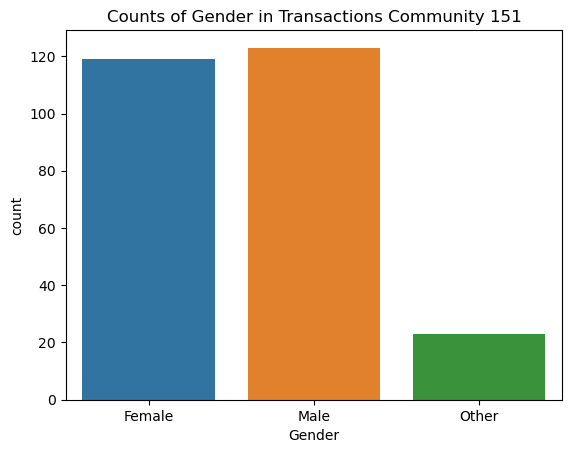

In [102]:
# Show Gender value counts
ax = sns.countplot(com151_custs, x='Gender')
plt.title('Counts of Gender in Transactions Community 151');

### High Risk Individuals (HRIs)

In [60]:
# Create a function to get number of transactions per individual in community
def trxn_count(com_num):
    """
    """
    # Get the individuals in community com_num and create a dataframe to get number of transactions/individual
    member_list = list(flatten(subgraphs[com_num]))
    df = pd.DataFrame({'Global_id': member_list})
    count = pd.DataFrame(df.groupby(['Global_id'])['Global_id'].count()).rename(columns={'Global_id':'Num Community Transactions'})
    count = count.reset_index().sort_values(by='Num Community Transactions', ascending=False)
    
    return count

Note: This was from another investigation for community 6. Due to time constraint and the long run-time of this notebook, we will keep this result here as an example.

In [96]:
# Get transaction count per member in the community
c6_count = trxn_count(6)
c6_count

,Global_id,Num Community Transactions
7,72009,26
12,125194,10
5,58590,4
15,190542,3
0,11543,2
10,115001,1
14,158147,1
13,129484,1
11,115403,1
8,79786,1


In [80]:
# Merge the customer details to the dataframe
com6_custs1 = pd.merge(com6_custs, c6_count, how='left', on='Global_id')
com6_custs1

,Global_id,Occupation,Age,Tenure,label,Gender_female,Gender_male,Occupation_num,Num_wires_sent,Avg_wire_amt_sent,...,Num_emt_rec_ext,Avg_emt_rec_ext,Num_emt_sent_ext,Avg_emt_sent_ext,Num_emt_rec_int,Avg_emt_rec_int,Num_emt_sent_int,Avg_emt_sent_int,Gender,Num Community Transactions
0,58590,Auctioneer,35.0,9.0,1,1,0,16,3,3691.666667,...,5,1688.600000,1,1450.000000,5,972.900000,3,169.166667,Female,4
1,115403,Sports Agent,38.0,12.0,0,1,0,214,1,1907.500000,...,6,1006.416667,1,1952.000000,4,86.750000,1,546.000000,Female,1
2,72009,Nightclub or Bar Owner,43.0,19.0,1,0,1,151,0,0.000000,...,1,685.000000,1,536.000000,4,520.250000,2,331.250000,Male,26
3,69817,Fast Food Worker,23.0,0.0,0,0,1,78,0,0.000000,...,1,270.000000,0,0.000000,1,210.000000,0,0.000000,Male,1
4,57602,Firefighter,42.0,0.0,0,0,1,82,0,0.000000,...,0,0.000000,0,0.000000,1,128.000000,2,146.500000,Male,1
5,32318,International Consultant,43.0,25.0,1,1,0,113,5,5919.700000,...,2,608.750000,4,230.750000,5,1513.200000,4,358.625000,Female,1
6,115001,Import/Export Business Owner,40.0,19.0,1,0,1,110,4,6113.000000,...,2,638.000000,1,265.500000,1,1313.000000,3,620.500000,Male,1
7,125194,Wedding Planner,49.0,3.0,0,0,1,247,0,0.000000,...,3,663.500000,3,656.333333,8,817.062500,2,646.500000,Male,10
8,11543,Semiotician,56.0,8.0,0,0,1,205,0,0.000000,...,0,0.000000,1,34.000000,1,169.500000,1,40.000000,Male,2
9,79786,Art Dealer,30.0,4.0,1,0,1,10,0,0.000000,...,0,0.000000,0,0.000000,0,0.000000,5,138.700000,Male,1


# Transaction Edge Analysis

### Get transactions in Community 151

In [240]:
gpby_comm[gpby_comm['Community Label'] == 151]

,Community Label,trxn_id,Num_trxns
151,151,"[NVCM93010345, URTY59701212, GJTB13119898, JKS...",499


In [241]:
# Get the transactions from the community
com151_trxns = list(gpby_comm[gpby_comm['Community Label'] == 151]['trxn_id'].values[0])
com151_trxns

['NVCM93010345',
 'URTY59701212',
 'GJTB13119898',
 'JKSI41633273',
 'PQFK85669398',
 'FFZW86658509',
 'WINT89943765',
 'SQRW65547541',
 'BVZV82707806',
 'DSMX46764362',
 'RADA25462184',
 'CNYW39555253',
 'QPKG72752445',
 'MJRB55614802',
 'MJWF72580391',
 'QIWQ21095751',
 'OHHT43857460',
 'GHUV70308152',
 'DUSP84317261',
 'CESD92603956',
 'FBSZ63884057',
 'ECYT11659356',
 'OCOK98917818',
 'TXEP92173030',
 'OKYV60460856',
 'RAHB20681502',
 'TUWM51118524',
 'FGVM14067225',
 'MWTR46659065',
 'HBBE77786919',
 'JCSR63662365',
 'BCRV27002410',
 'LTCI25214358',
 'ABQE82922245',
 'CPCT49953473',
 'RRWW28047504',
 'NQOK97533260',
 'RCAI64819048',
 'VJVE32962645',
 'CHKD32038994',
 'UPDN60399061',
 'RFBN31748112',
 'VLCL78148539',
 'MKPX64611503',
 'WCPO38752953',
 'NAXW91967675',
 'AHMA27934424',
 'QWFC23599806',
 'JFUN73010826',
 'IQUU20555933',
 'WUMF38581473',
 'FFQY71975393',
 'BZRS31124191',
 'GHQR24177528',
 'CEOZ58513051',
 'PEZQ92914558',
 'UZME13611838',
 'BFTQ84161407',
 'CPNJ15255923

### Import transaction subgraph edges

In [242]:
# Import edges
wsw_edges = pd.read_csv('wsw_edges.csv').iloc[:, 1:]
wse_edges = pd.read_csv('wse_edges.csv').iloc[:, 1:]
wsc_edges = pd.read_csv('wsc_edges.csv').iloc[:, 1:]
ese_edges = pd.read_csv('ese_edges.csv').iloc[:, 1:]
esc_edges = pd.read_csv('esc_edges.csv').iloc[:, 1:]
esw_edges = pd.read_csv('esw_edges.csv').iloc[:, 1:]
csc_edges = pd.read_csv('csc_edges.csv').iloc[:, 1:]
csw_edges = pd.read_csv('csw_edges.csv').iloc[:, 1:]
cse_edges = pd.read_csv('cse_edges.csv').iloc[:, 1:]

In [243]:
# Import transaction id map
trxn_map = pd.read_csv('trxn_map.csv').iloc[:, 1:]
trxn_map

,trxn_id,index
0,LWCS42954834,0
1,NTTG55749308,1
2,IXVD84599097,2
3,SLBV29462341,3
4,ERLU26785367,4
...,...,...
457416,JOQU43611104,457416
457417,LTBH81014009,457417
457418,GGHM25093698,457418
457419,CNXP31340871,457419


### Count occurances of each edge type

In [244]:
# get the indexes and ids
indexes = list(trxn_map['index'].values)
ids = list(trxn_map['trxn_id'].values)

In [245]:
# Remap the edges to the original transaction id
# create a dictionary for the mapped indexes
t_map = {index:gid for gid, index in zip(ids, indexes)}

In [246]:
# Create a list of edges to remap
edge_dfs = [wsw_edges, wse_edges, wsc_edges,
            ese_edges, esc_edges, esw_edges, 
            csc_edges, csw_edges, cse_edges]

In [247]:
# Create a list of edges to remap
edge_names = ['wsw_edges',' wse_edges', 'wsc_edges',
            'ese_edges', 'esc_edges', 'esw_edges', 
            'csc_edges', 'csw_edges', 'cse_edges']

In [248]:
# create a function to map edges with the corresponding index values in the node features dataframe
def map_edges(df):
    """
    """
    edges_df = pd.DataFrame()
    edges_df['Source'] = df['Source'].map(t_map)
    edges_df['Destination'] = df['Destination'].map(t_map)
    edges_df['Weight'] = df['Weight']
    
    return edges_df

In [249]:
# create a dict to store the remapped edge_dfs
mapped_edf = {}

In [250]:
# Use a for loop to remap the edges
for i in range(len(edge_dfs)):
    mapped_edf[edge_names[i]] = map_edges(edge_dfs[i])

In [253]:
# Create a list to store the number of occurances of each transaction in each edges_df
src_counts = []
dst_counts = []

In [254]:
# Extract the number of occurances
for i in range(len(edge_dfs)):
    
    src_count = 0
    dst_count = 0
    
    # get dataframe
    df = mapped_edf[edge_names[i]]
    
    # filter df for where source/destination is in com6_trxns
    srcs = df[df['Source'].isin(com151_trxns)]
    dsts = df[df['Destination'].isin(com151_trxns)]
    
    src_counts.append(len(srcs))
    dst_counts.append(len(dsts))

In [255]:
# Create a dataframe with the counts for each edge type
ce_data = {'Edge Type': edge_names, 'Source Counts': src_counts, 'Destination Counts': dst_counts}
comm_edges = pd.DataFrame(ce_data)
comm_edges

,Edge Type,Source Counts,Destination Counts
0,wsw_edges,94,93
1,wse_edges,444,442
2,wsc_edges,47,47
3,ese_edges,108,109
4,esc_edges,30,29
5,esw_edges,34,34
6,csc_edges,6,3
7,csw_edges,132,133
8,cse_edges,511,511


There are 511 occurances of a community 151 transaction in the cse_edges. In other words, of the transactions in this community, the total number of times any one of the transactions appeared in the cash-same-emt subgraph was 511 times. Therefore transactions in this community are frequently appearing in cash-same-emt transactions which are representative of individuals depositing cash then sending an emt of a smaller or equal amount.